## 0. 라이브러리 / 기본셋업

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

In [2]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}

DATA_PATH = '../../data/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)
test = pd.read_csv('../../data/test_data.csv', dtype=dtype, parse_dates=['Timestamp'])
test = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)


CPU times: user 5.71 s, sys: 612 ms, total: 6.32 s
Wall time: 6.34 s


## 1.1 기본적인 내용 파악

정리하면, 
+ `userID` 사용자의 고유 번호입니다. 총 7,442명의 학생
+ `assessmentItemID` 사용자가 푼 문항의 일련 번호
+ `testID` 사용자가 푼 문항이 포함된 시험지의 일련번호
+ `answerCode` 사용자가 푼 문항의 정답 여부 (0/1)
+ `Timestamp` 사용자가 문항을 푼 시간 정보
+ `KnowledgeTag` 사용자가 푼 문항의 고유 태그

### 특성의 기본 정보

In [3]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [4]:
print(f"""
--- BASIC INFORMATIONS ---
user ID          : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df.answerCode.sum()/df.shape[0]:.2%}
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}
""")


--- BASIC INFORMATIONS ---
user ID          : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------



### 일련번호 분석

#### 첫 번째 단어 A
A 밖에 없는 것을 확인할 수 있음

In [5]:
df['assessmentItemID'].apply(lambda x: x[0]).unique()

array(['A'], dtype=object)

#### 문항 일련 번호 내 시험지 번호
- 문항 일련 번호의 1~6번째 자리 = 시험지 번호의 1~3번째+마지막3자리 확인 <br>
-> 다른 것 없음
<br>
- `assessmentItemID`, `testId` 분해하여 feature 생성

In [6]:
sum(df['assessmentItemID'].apply(lambda x: x[1:7]) != df['testId'].apply(lambda x: x[1:4]+x[7:]))

0

In [282]:
df['assessmentItemID_last3'] = df['assessmentItemID'].apply(lambda x: x[-3:]).astype('uint8')

In [283]:
df['testId_first3'] = df['testId'].apply(lambda x: x[2]).astype('uint8')
df['testId_last3'] = df['testId'].apply(lambda x: x[-3:]).astype('uint8')

#### 시험지 번호 가운데 3자리 모두 000

In [7]:
sum(df['testId'].apply(lambda x: x[4:7]) != '000')

0

#### 학생 별 중복으로 푼 문제수
- 699명의 학생이 동일한 문제를 푼 적 있음
- 최소 4문제에서 최대 433문제를 중복으로 품
- 2번 혹은 3번 중복으로 품
- 중복으로 푼 문제는 정답률이 높을까? -> 마지막 문제에 맞추는 비율 약 64%로 전체 정답률 약 65%보다 낮음

In [150]:
# 학생 별 중복으로 푼 문제수
user_repl = df.groupby('userID').apply(lambda x: sum(x['assessmentItemID'].value_counts()>1))
user_repl[user_repl>0].describe()

count    699.000000
mean      64.547926
std       76.633287
min        4.000000
25%       14.000000
50%       33.000000
75%       85.000000
max      433.000000
dtype: float64

In [160]:
user_prob_count = df[df.userID.isin(user_repl[user_repl>0].index)].groupby('userID').apply(lambda x: x['assessmentItemID'].value_counts()).to_frame().reset_index()
user_prob_count.columns = ['userID', 'assessmentItemID', 'val_count']
user_prob_count

,userID,assessmentItemID,val_count
0,1,A040161004,2
1,1,A040165001,2
2,1,A040161001,2
3,1,A040160005,2
4,1,A040160004,2
...,...,...,...
351937,7329,A040196001,1
351938,7329,A040196002,1
351939,7329,A040196003,1
351940,7329,A040196004,1


In [161]:
user_prob_count.val_count.value_counts()

1    306823
2     44285
3       834
Name: val_count, dtype: int64

In [204]:
df_dup = df.merge(user_prob_count[user_prob_count.val_count>=2], how='inner', on=['userID', 'assessmentItemID'])
percentile(df_dup.groupby(['userID', 'assessmentItemID'])['answerCode'].apply(lambda x: True if x.iloc[-1]==1 else False))
# 

0.6432545047540947

In [205]:
df.answerCode.mean()

0.654378435232548

## 1.2 기술 통계량 분석

In [8]:
def percentile(s):
    return np.sum(s)/len(s)

#### 사용자 분석

In [9]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.describe()

,assessmentItemID,answerCode
count,6698.000000,6698.000000
mean,338.397432,0.628909
std,321.331429,0.159639
min,9.000000,0.000000
25%,78.000000,0.527273
50%,231.500000,0.651757
75%,513.000000,0.751203
max,1860.000000,1.000000


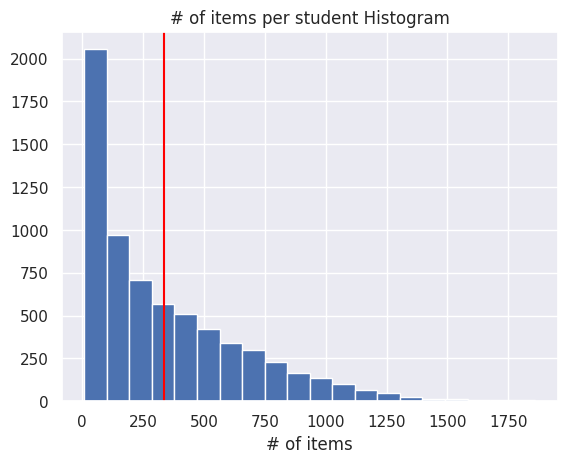

In [10]:
fig, ax = plt.subplots()

stu_groupby['assessmentItemID'].hist(bins=20, ax=ax)
ax.axvline(stu_groupby['assessmentItemID'].mean(), color='red')
ax.set_title('# of items per student Histogram')
ax.set_xlabel('# of items')
plt.show()

#### 사용자 정답률 도수분포표

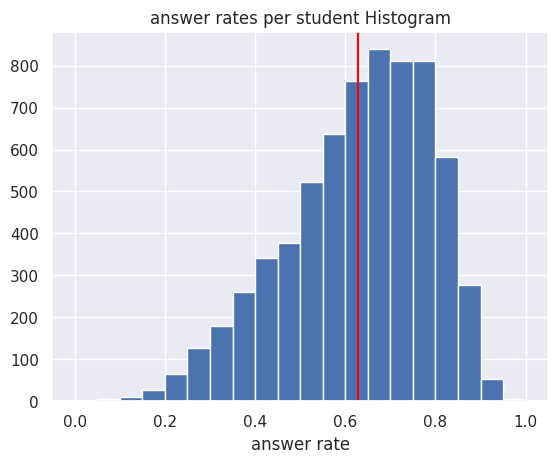

In [11]:
fig, ax = plt.subplots()

stu_groupby['answerCode'].hist(bins=20, ax=ax)

ax.set_title('answer rates per student Histogram')
ax.set_xlabel('answer rate')
ax.axvline(stu_groupby['answerCode'].mean(), color='red')

plt.show()

#### 문항 별 정답률 분석

In [12]:
prob_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile
})
prob_groupby.describe()

,userID,answerCode
count,9454.000000,9454.000000
mean,239.748889,0.654256
std,71.893791,0.195488
min,43.000000,0.049430
25%,220.000000,0.505548
50%,230.000000,0.666667
75%,271.000000,0.820513
max,454.000000,0.996310


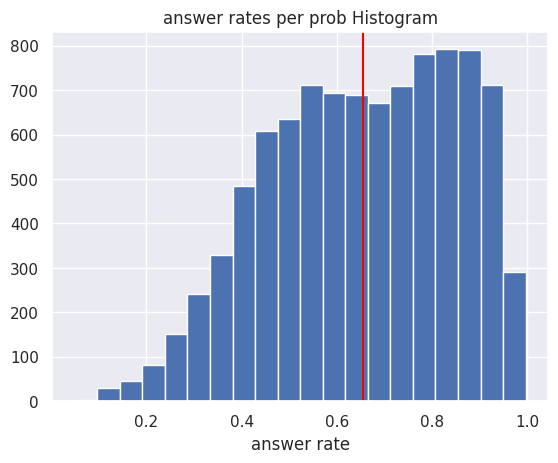

In [13]:
fig, ax = plt.subplots()
prob_groupby['answerCode'].hist(bins=20, ax=ax)
ax.set_title('answer rates per prob Histogram')
ax.set_xlabel('answer rate')
ax.axvline(prob_groupby['answerCode'].mean(), color='red')
plt.show()

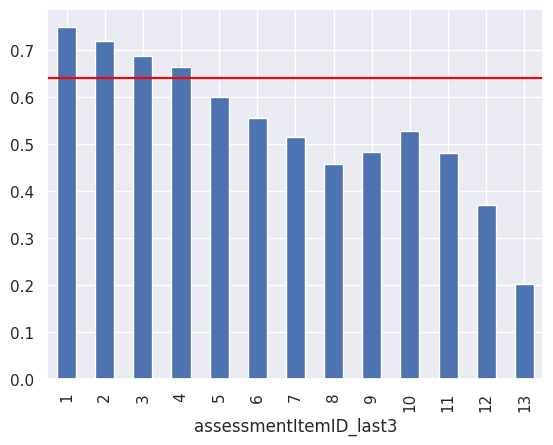

In [293]:
fig, ax = plt.subplots()
df.groupby(['assessmentItemID_last3'])['answerCode'].mean().plot(kind='bar')
ax.axhline(df.groupby('testId_first3')['answerCode'].mean().mean(), color='red')

# 문항 번호 별로 난이도 다른듯

#### 시험지 별 정답률 분석

In [14]:
test_groupby = df.groupby('testId').agg({
    'userID': 'count',
    'answerCode': percentile
})
test_groupby.describe()

,userID,answerCode
count,1537.000000,1537.000000
mean,1474.681848,0.667982
std,533.526783,0.138903
min,172.000000,0.327186
25%,1320.000000,0.561819
50%,1400.000000,0.680519
75%,1602.000000,0.778439
max,3960.000000,0.955474


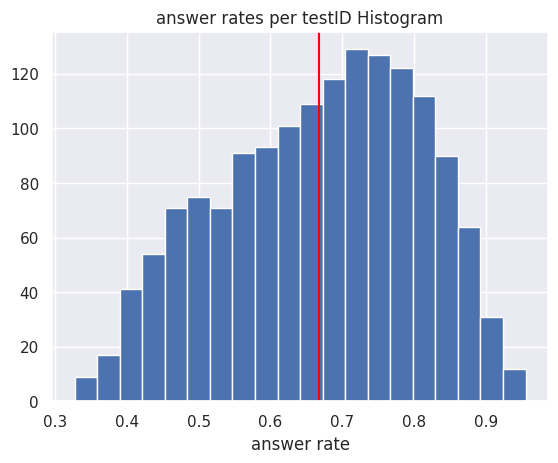

In [15]:
fig, ax = plt.subplots()
test_groupby['answerCode'].hist(bins=20, ax=ax)
ax.set_title('answer rates per testID Histogram')
ax.set_xlabel('answer rate')
ax.axvline(test_groupby['answerCode'].mean(), color='red')
plt.show()

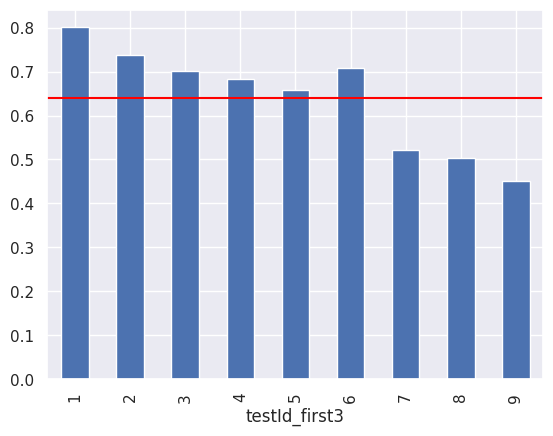

In [292]:
fig, ax = plt.subplots()
df.groupby('testId_first3')['answerCode'].mean().plot(kind='bar')
ax.axhline(df.groupby('testId_first3')['answerCode'].mean().mean(), color='red')
# testId의 첫 3자리(1~9)에 따라 정답률 상이

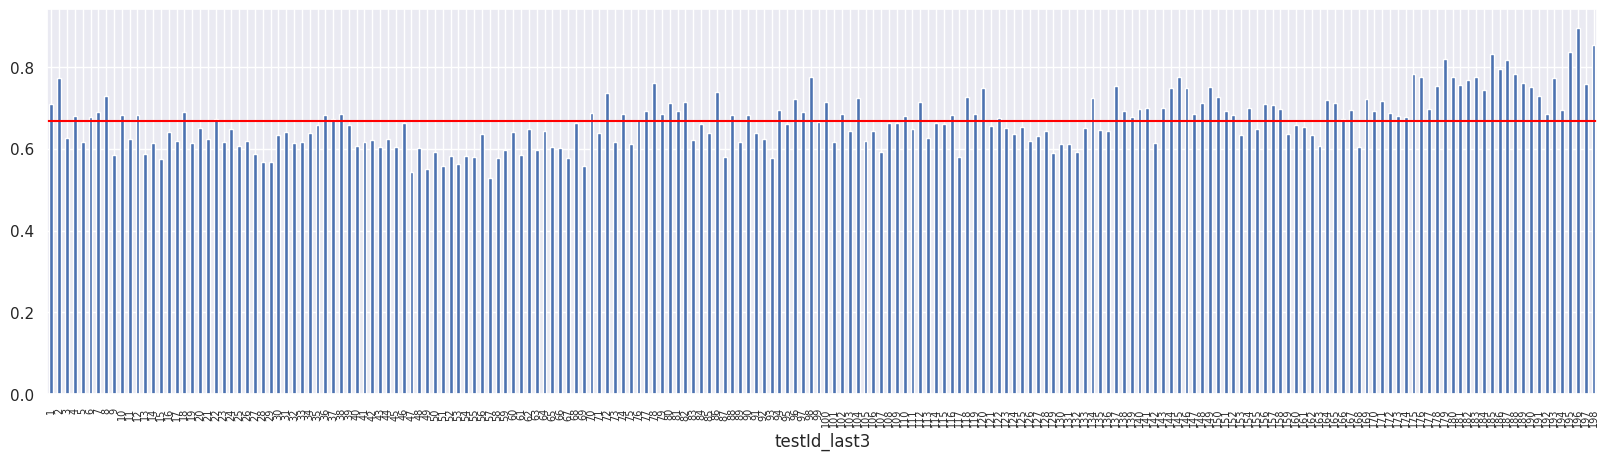

In [303]:
fig, ax = plt.subplots(figsize=(20,5))
df.groupby('testId_last3')['answerCode'].mean().plot(kind='bar')
ax.axhline(df.groupby('testId_last3')['answerCode'].mean().mean(), color='red')
ax.tick_params(axis='x', labelsize=7)

#### tag 별 정답률 분석

In [40]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag'],
      dtype='object')

In [46]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID': ['count', 'nunique'],
    'answerCode': percentile
})
tag_groupby.describe()

userID               answerCode
              count      nunique  percentile
count    912.000000   912.000000  912.000000
mean    2485.291667   483.335526    0.615524
std     1732.086925   148.554696    0.148329
min       44.000000    42.000000    0.188940
25%     1025.250000   410.000000    0.498239
50%     2204.000000   504.000000    0.599585
75%     4052.750000   584.000000    0.740288
max    12892.000000  1027.000000    0.977778

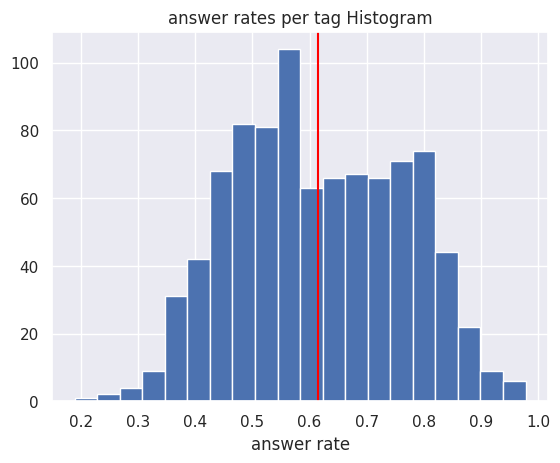

In [52]:
fig, ax = plt.subplots()
tag_groupby['answerCode'].hist(bins=20, ax=ax)
ax.set_title('answer rates per tag Histogram')
ax.set_xlabel('answer rate')
ax.axvline(tag_groupby['answerCode'].mean()[0], color='red')
plt.show()
# 정답률이 0.6보다 작은 tag들 많음

## 1.3 일반적인 EDA

#### 문항을 더 많이 푼 학생이 문제를 더 맞추는가?
-> 문항을 더 많이 푼 학생일 수록 정답률이 높은 경향이 있음

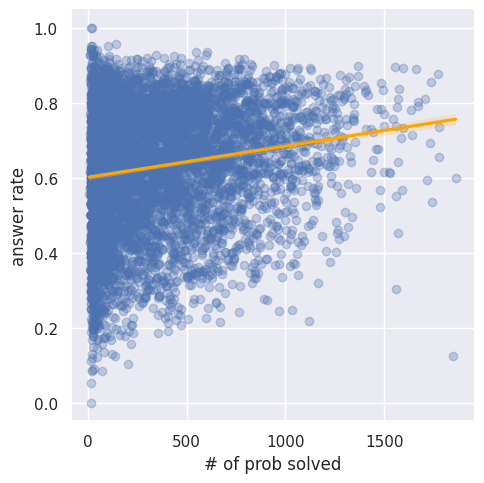

In [16]:
g = sns.lmplot(
    data=stu_groupby,
    x='assessmentItemID',
    y='answerCode',
    scatter_kws={'alpha':0.3},
    line_kws={'color': 'orange'}
)
g.set_xlabels('# of prob solved')
g.set_ylabels('answer rate')


In [17]:
print(f"정답률과 문제를 푼 개수 사이 상관계수: {stu_groupby.corr()['assessmentItemID']['answerCode']:.3f}")


정답률과 문제를 푼 개수 사이 상관계수: 0.168


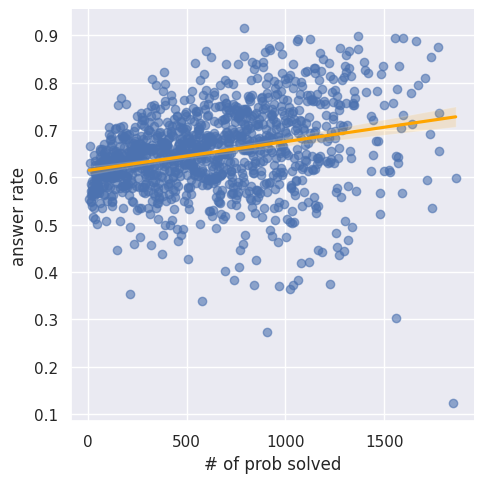

In [33]:
mean_per_num = stu_groupby.groupby('assessmentItemID').agg({
    'answerCode': "mean"
}).reset_index()
g = sns.lmplot(
    data=mean_per_num,
    x='assessmentItemID',
    y='answerCode',
    scatter_kws={'alpha':0.6},
    line_kws={'color': 'orange'}
)
g.set_xlabels('# of prob solved')
g.set_ylabels('answer rate')


In [34]:
itemnum_ans = stu_groupby.groupby('assessmentItemID').mean()
bins = 300
itemnum_ans['bins'] = pd.cut(
    itemnum_ans.index,
    [i * (itemnum_ans.index.max() - itemnum_ans.index.min()) // bins for i in range(bins)]
)

In [35]:
itemnum_ans

,answerCode,>stu_num_mean,bins
assessmentItemID,,,
9,0.555556,0.0,"(6.0, 12.0]"
13,0.666667,0.0,"(12.0, 18.0]"
14,0.629870,0.0,"(12.0, 18.0]"
15,0.612963,0.0,"(12.0, 18.0]"
16,0.547697,0.0,"(12.0, 18.0]"
...,...,...,...
1773,0.875353,1.0,"(1770.0, 1776.0]"
1774,0.735626,1.0,"(1770.0, 1776.0]"
1777,0.656162,1.0,"(1776.0, 1783.0]"


In [38]:
itemnum_ans = itemnum_ans.groupby('bins').mean()
itemnum_ans['mid'] = list(map(lambda x: (x.left + x.right)//2, itemnum_ans.index))

Text(0, 0.5, 'Answer Rate')

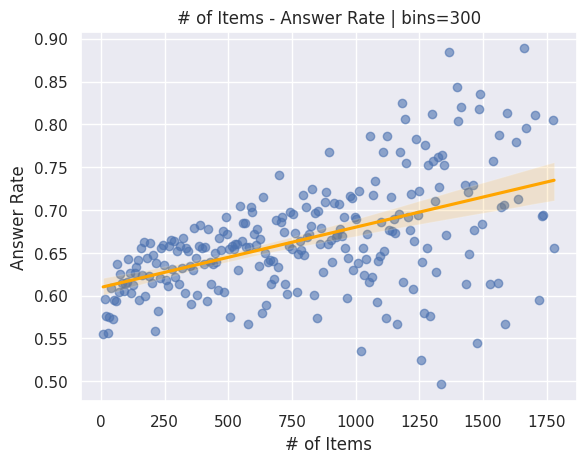

In [39]:
fig, ax = plt.subplots()
sns.regplot(data=itemnum_ans, x='mid', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha': 0.6}, ax=ax)

ax.set_title(f'# of Items - Answer Rate | bins={bins}')
ax.set_xlabel('# of Items')
ax.set_ylabel('Answer Rate')
# 문항을 많이 푼 학생일수록 평균적으로 정답률이 높음

In [20]:
stu_groupby['>stu_num_mean'] = (stu_groupby['assessmentItemID']>stu_groupby['assessmentItemID'].mean()).astype('int8')

<AxesSubplot: xlabel='answerCode', ylabel='Probability'>

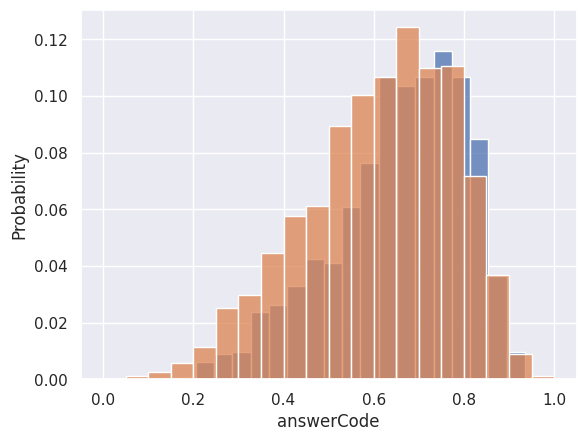

In [29]:
# sns.histplot(x='answerCode', data=stu_groupby, hue='>stu_num_mean',
#     bins=20, stat='probability'
# )

sns.histplot(x='answerCode', data=stu_groupby[stu_groupby['assessmentItemID']>=stu_groupby['assessmentItemID'].mean()],
    bins=20, stat='probability'
)
sns.histplot(x='answerCode', data=stu_groupby[stu_groupby['assessmentItemID']<stu_groupby['assessmentItemID'].mean()],
    bins=20, stat='probability'
)

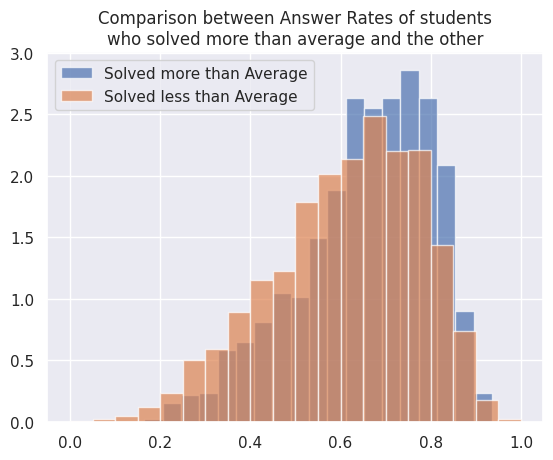

In [76]:
fig, ax = plt.subplots()

ax.set_title('Comparison between Answer Rates of students\nwho solved more than average and the other')
stu_num_mean = stu_groupby['assessmentItemID'].mean()
stu_groupby[stu_groupby['assessmentItemID'] >= stu_num_mean]['answerCode'].hist(
    bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved more than Average'
)
stu_groupby[stu_groupby['assessmentItemID'] < stu_num_mean]['answerCode'].hist(
    bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved less than Average'
)
ax.legend()

#### 그렇다면 문항을 풀수록 정답률이 높아지는가?
-> 높아지는 경향이 있음
<br>
-> 누적 문항 수

In [94]:
cum_ans = pd.concat([df.groupby('userID')['answerCode'].cumsum(), (df.groupby('userID')['answerCode'].cumcount() + 1)], axis=1).rename(columns={'answerCode':'sum_answer', 0:'count_answer'})
cum_ans['answer_rate'] = cum_ans['sum_answer'] / cum_ans['count_answer']
cum_ans['userID'] = df['userID']
cum_ans = cum_ans[['userID', 'sum_answer', 'count_answer', 'answer_rate']]

cum_ans


,userID,sum_answer,count_answer,answer_rate
0,0,1,1,1.000000
1,0,2,2,1.000000
2,0,3,3,1.000000
3,0,4,4,1.000000
4,0,5,5,1.000000
...,...,...,...,...
2266581,7441,1,5,0.200000
2266582,7441,2,6,0.333333
2266583,7441,3,7,0.428571
2266584,7441,4,8,0.500000


In [129]:
cum_ans.groupby('count_answer')['answer_rate'].mean().reset_index().head(50)

,count_answer,answer_rate
0,1,0.717528
1,2,0.701105
2,3,0.685080
3,4,0.666132
4,5,0.646193
5,6,0.643301
6,7,0.643433
7,8,0.643326
8,9,0.641021
9,10,0.638420


<AxesSubplot: xlabel='count_answer', ylabel='Count'>

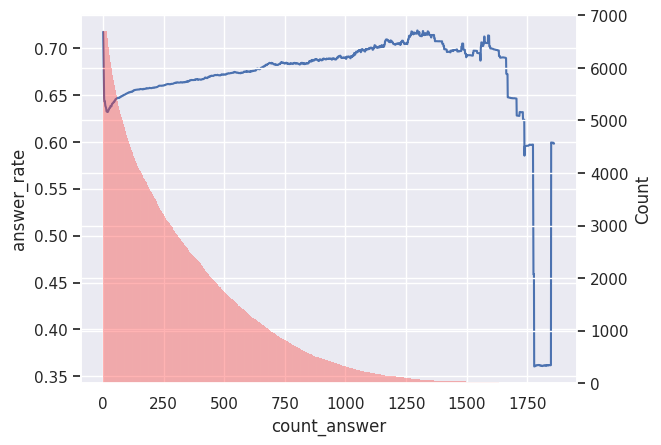

In [130]:
fig, ax = plt.subplots(sharey=True)
sns.lineplot(
    data=cum_ans.groupby('count_answer')['answer_rate'].mean().reset_index(),
    x='count_answer',
    y='answer_rate',
    ax=ax
)
ax2 = ax.twinx()
sns.histplot(
    data=cum_ans,
    x='count_answer',
    bins=1860,
    color='red',
    alpha=0.3,
    ax=ax2
)
# 평균적으로 초반에 정답률 높다가 15~22문제까지 정답률 하락 후 다시 점차 증가

<AxesSubplot: xlabel='count_answer', ylabel='answer_rate'>

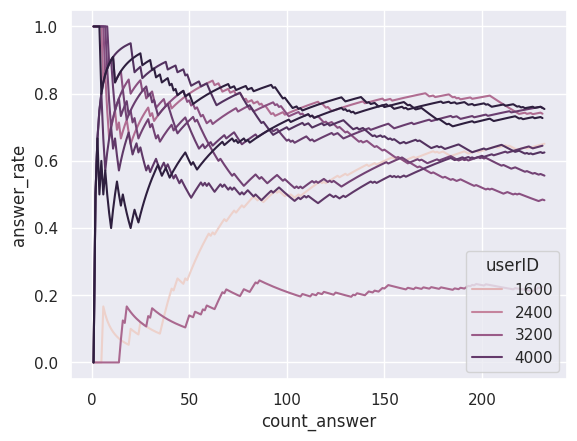

In [101]:
ids = df.groupby('userID').agg({
    'assessmentItemID': 'count'
}).sort_values('assessmentItemID').iloc[(df.userID.nunique()//2-5):(df.userID.nunique()//2+5)].index.to_list()


sns.lineplot(data=cum_ans[cum_ans['userID'].isin(ids)], x='count_answer', y='answer_rate', hue='userID')

#### 문제 푼 속도에 따라 정답률 다를까?
- 시험지 별로 2번째 문제부터 마지막 문제까지 푼 시간 구할 수 있음

In [223]:
time_diff = df.groupby(['userID', 'testId'], group_keys=True)['Timestamp'].diff().fillna(pd.Timedelta(seconds=0))
df['elapsed'] = time_diff.apply(lambda x: x.total_seconds())

In [225]:
df['elapsed'].describe()

count    2.266586e+06
mean     1.448600e+04
std      3.546711e+05
min      0.000000e+00
25%      3.000000e+00
50%      2.000000e+01
75%      5.400000e+01
max      2.869588e+07
Name: elapsed, dtype: float64

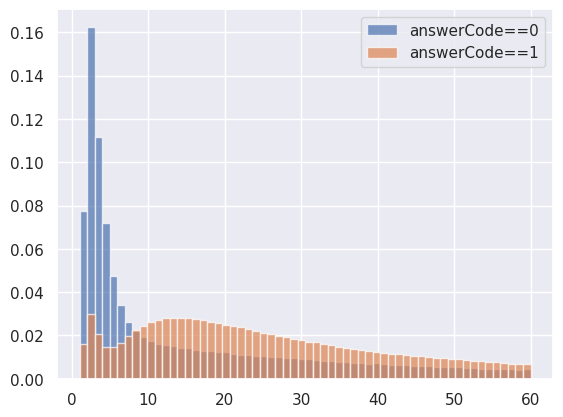

In [247]:
fig, ax = plt.subplots()
df[(df.answerCode==0) & (df.elapsed <= 60) & (df.elapsed!=0)]['elapsed'].hist(
    bins=60, ax=ax, alpha=0.7, stacked=True, density=1, label='answerCode==0'
)
df[(df.answerCode==1) & (df.elapsed <= 60) & (df.elapsed!=0)]['elapsed'].hist(
    bins=60, ax=ax, alpha=0.7, stacked=True, density=1, label='answerCode==1'
)
ax.legend()
plt.show()

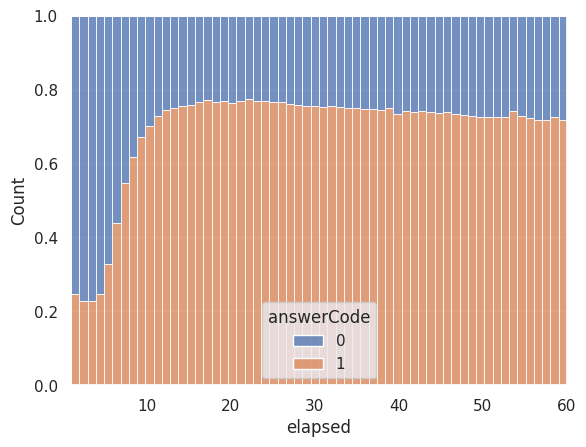

In [253]:
fig, ax = plt.subplots()
sns.histplot(
    x='elapsed', data=df[(df.elapsed <= 60) & (df.elapsed!=0)], ax=ax,
    fill=True, 
    bins=60,
    hue='answerCode', 
    multiple="fill", # layer, stack, fill
)
plt.show()